In [3]:
import pypsa
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib as mpl
import tsam.timeseriesaggregation as tsam
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

sys.path.insert(1, '/media/pklein/SATA_SSD/GitHub/pypsa_utilities/eskom data/')
sys.path.insert(1, '/mnt/wsl/PHYSICALDRIVE0p1/GitHub/pypsa_utilities/eskom data/')

import data_utilities as du
import plotting_utilities as pu
import financial_utilities as fu
import xarray as xr
import cartopy.crs as ccrs
from pypsa.descriptors import get_switchable_as_dense as get_as_dense
import geopandas as gpd
import rasterio
from rasterio.plot import show
import numpy as np
from shapely.geometry import shape
import rioxarray
import atlite
import shapely
import warnings
warnings.filterwarnings(action='ignore', category=RuntimeWarning) 

from pypsa.descriptors import (
    Dict,
    additional_linkports,
    expand_series,
    get_active_assets,
    get_activity_mask,
    get_bounds_pu,
    get_extendable_i,
    get_non_extendable_i,
    nominal_attrs,
)

%run ../scripts/_helpers.py

ERROR 1: PROJ: proj_create_from_database: Open of /home/pklein/anaconda3/envs/pypsa-eur/share/proj failed
/home/pklein/anaconda3/envs/pypsa-eur/lib/python3.10/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.13) or chardet (None)/charset_normalizer (3.0.1) doesn't match a supported version!
  warnings.warn(


In [2]:
mpl.rcParams['font.family'] = "sans-serif"
mpl.rcParams['font.sans-serif'] = ['Tahoma', 'DejaVu Sans', 'Lucida Grande', 'Verdana']
mpl.style.use('Meridian.mplstyle')

In [3]:
colour_map={'onwind':'#77D1E4',
            'onwind_100MW':'#2eb8d6',
            'solar':'#FFBB4E',
            'solar_pv_1MW':'#FBDC81',
            'solar_pv_100MW':'#F99B00',
            'CSP':'#feed82',
            'battery':'#cba3cb',
            'bat_c':'#AA68AA',#CBA3CB
            'bat_d':'#AA68AA',
            'PHS':'#873f91',
            'phs_c':'#873f91',
            'phs_d':'#873f91',
            'coal':'#3C3C3C',
            'hydro':'#004F95',
            'hydro-import':'#004F95',
            'other':'#004F95',
            'ocgt':'#8D7867',
            'diesel':'#8D7867',
            'gas':'#8D7867',
            'OCGT':'#8D7867',
            'CCGT':'#ffa69e',
            'rmippp':'#51969B',
            'biomass':'#8C9A07',
            'nuclear':'#C84936',
            'demand_response':'#817E80',
            'loadshedding':'#DE9287'}

In [23]:
# Load PyPSA networks from results folder
n={}
#n['LC_UNC'] = pypsa.Network('../results/networks/solved_val-LC-UNC-1_RSA_redz_lcopt_LC.nc')
n['LC_SMOOTH'] = pypsa.Network('../results/networks/solved_val-LC-SMOOTH-1_RSA_redz_lcopt_LC.nc')
#n['LC_UNC-1000SEG'] = pypsa.Network('../results/networks/solved_val-LC-UNC-1_RSA_redz_lcopt_LC-1000SEG.nc')
#n['2Gt_UNC'] = pypsa.Network('../results/networks/solved_val-2Gt-UNC_RSA_redz_lcopt_Co2L.nc')
#n['2Gt_SMOOTH'] = pypsa.Network('../results/networks/solved_val-2Gt-SMOOTH_RSA_redz_lcopt_Co2L.nc')

INFO:pypsa.io:Imported network solved_val-LC-SMOOTH-1_RSA_redz_lcopt_LC.nc has buses, carriers, generators, global_constraints, loads, storage_units


In [24]:
# Generate a DataFrame for the capacity and energy
scenario ='LC_SMOOTH'
seg=""
capacity = aggregate_capacity(n[scenario+seg])/1000
energy = aggregate_energy(n[scenario+seg])/1e6

capacity.loc['hydro',:] = capacity.loc['hydro',:]+capacity.loc['hydro-import',:]
energy.loc['hydro',:] = energy.loc['hydro',:]+energy.loc['hydro-import',:]

capacity.loc['other',:]= capacity.loc['hydro',:]+capacity.loc['biomass',:]
energy.loc['other',:] = energy.loc['hydro',:]+energy.loc['biomass',:]

capacity = capacity.drop(['load_shedding','hydro-import'])
energy = energy.drop(['load_shedding','hydro-import'])

ambitions_capacity = pd.read_excel(
    '../data/ambitions_validation.xlsx',
    sheet_name = 'capacity_CSIR_'+scenario,
    index_col=0
)/1000

ambitions_energy = pd.read_excel(
    '../data/ambitions_validation.xlsx',
    sheet_name = 'energy_CSIR_'+scenario,
    index_col=0
)/1000
ambitions_capacity['other'] = ambitions_capacity['hydro'] + ambitions_capacity['biomass']
ambitions_energy['other'] = ambitions_energy['hydro'] + ambitions_energy['biomass']

/home/pklein/anaconda3/envs/pypsa-eur/lib/python3.10/site-packages/pypsa/descriptors.py:371: FutureWarning:

In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.

/home/pklein/anaconda3/envs/pypsa-eur/lib/python3.10/site-packages/pypsa/descriptors.py:371: FutureWarning:

In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.

/home/pklein/anaconda3/envs/pypsa-eur/lib/python3.10/site-packages/pypsa/descriptors.py:371: FutureWarning:

In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.

/home/pklein/anaconda3/envs/pypsa-eur/lib/python3.10/site-packages/pypsa/descriptors.py:371: FutureWarning:

In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.

/home/pklein/anaconda3/envs/pypsa-eur/lib/python3.10/site-packages/pypsa/descriptors.py:371: FutureWarning:

In a future version of pandas all arguments of DataFrame.an

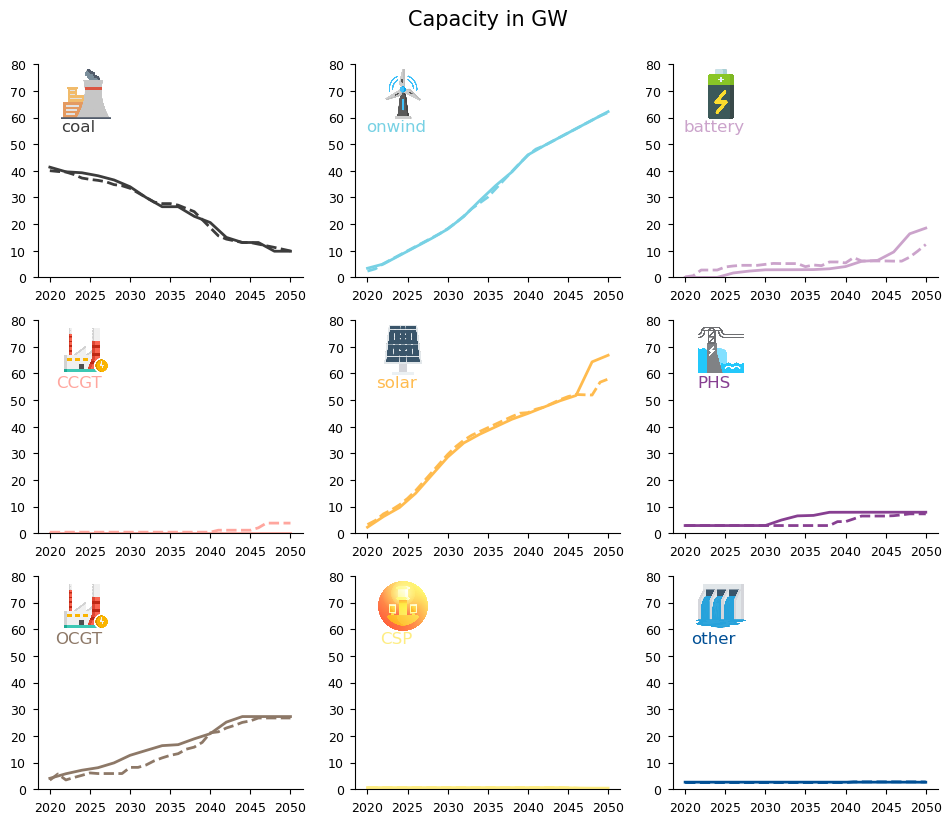

In [25]:
fig, axs = plt.subplots(3, 3, figsize=(12, 10))
y_max = 80
linewidth=2

technologies = ['coal', 'CCGT', 'OCGT', 'onwind', 'solar', 'CSP', 'battery', 'PHS', 'other']

BL_img = (0.18,0.2)
TL_img = (0.18,0.86)

BL_txt = (0.18,0.08)
TL_txt = (0.18,0.74)

img_coords = {
                'coal':TL_img,
                'CCGT':TL_img,
                'OCGT':TL_img,
                'onwind':TL_img,
                'solar':TL_img,
                'CSP':TL_img,
                'battery':TL_img,
                'PHS':TL_img,
                'other':TL_img,
}
txt_coords = {
                'coal':TL_txt,
                'CCGT':TL_txt,
                'OCGT':TL_txt,
                'onwind':TL_txt,
                'solar':TL_txt,
                'CSP':TL_txt,
                'battery':TL_txt,
                'PHS':TL_txt,
                'other':TL_txt,
}

row = 0
col = 0

for tech in technologies:
    ax = axs[row, col]
    img = mpimg.imread('../../icons/'+tech+'.png')
    capacity.loc[tech,:].plot(kind='line', ax=axs[row, col], ylim=([0,y_max]), color=colour_map[tech], linewidth=linewidth)
    ambitions_capacity[tech].plot(kind='line', ax=axs[row, col], xlabel='', color=colour_map[tech], linestyle='--', linewidth=linewidth)
    
    # Increment the row and column counters
    row += 1
    if row > 2:
        row = 0
        col += 1

    # Create an OffsetImage and AnnotationBbox
    imagebox = OffsetImage(img, zoom=0.07)
    ab = AnnotationBbox(imagebox, img_coords[tech], xycoords='axes fraction', frameon=False)
    
    # Add the AnnotationBbox to the plot
    ax.add_artist(ab)
    annotation=ax.annotate(tech, xy=txt_coords[tech], xycoords='axes fraction', fontsize=12,
            xytext=(-5, -5), textcoords='offset points', ha='center', va='center',
            color=colour_map[tech])

    annotation.set_fontfamily('sans-serif')

fig. suptitle("Capacity in GW", fontsize=15, y=0.93)
fig.savefig('line_capacity_'+scenario, dpi=150, bbox_inches='tight')

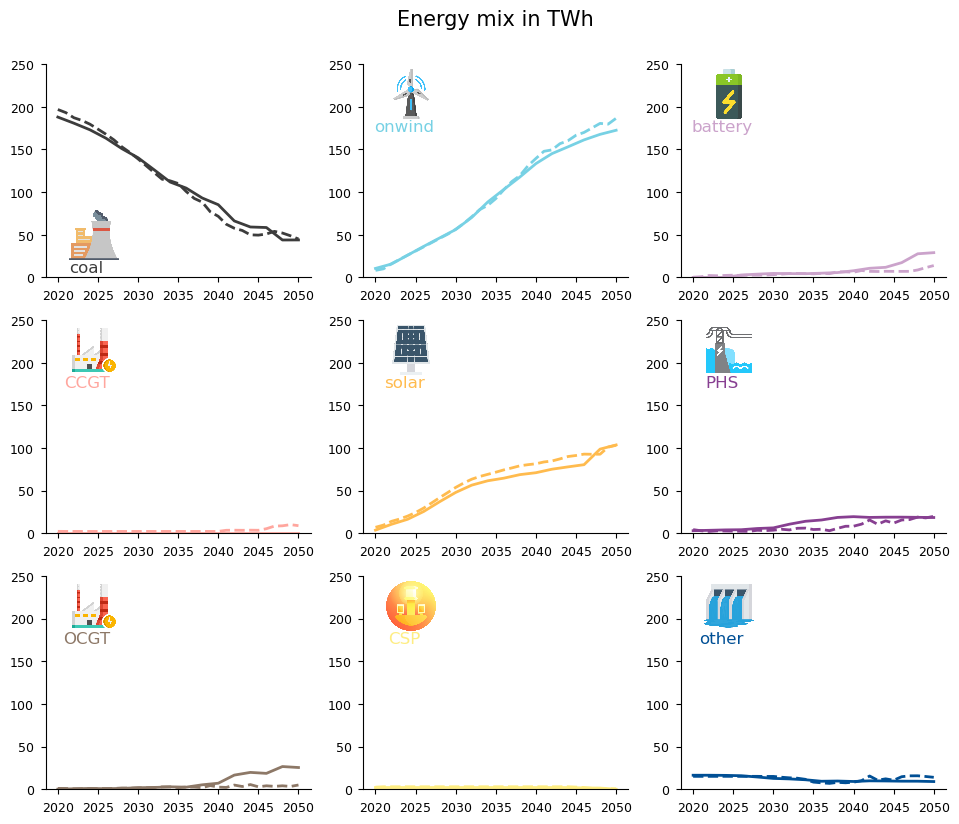

In [26]:
fig, axs = plt.subplots(3, 3, figsize=(12, 10))
y_max = 250
linewidth=2

technologies = ['coal', 'CCGT', 'OCGT', 'onwind', 'solar', 'CSP', 'battery', 'PHS', 'other']

BL_img = (0.18,0.2)
TL_img = (0.18,0.86)

BL_txt = (0.18,0.08)
TL_txt = (0.18,0.74)

img_coords['coal'] = BL_img
txt_coords['coal'] = BL_txt

row = 0
col = 0

for tech in technologies:
    ax = axs[row, col]
    img = mpimg.imread('../../icons/'+tech+'.png')
    energy.loc[tech,:].plot(kind='line', ax=ax, color=colour_map[tech], linewidth=linewidth)
    ambitions_energy[tech].plot(kind='line', ax=ax, color=colour_map[tech], linestyle='--', linewidth=linewidth)
    
    ax.set_ylim([0,y_max])
    ax.set_xlabel('')

    # Increment the row and column counters
    row += 1
    if row > 2:
        row = 0
        col += 1

    # Create an OffsetImage and AnnotationBbox
    imagebox = OffsetImage(img, zoom=0.07)
    ab = AnnotationBbox(imagebox, img_coords[tech], xycoords='axes fraction', frameon=False)
    
    # Add the AnnotationBbox to the plot
    ax.add_artist(ab)
    ax.annotate(tech, xy=txt_coords[tech], xycoords='axes fraction', fontsize=12,
            xytext=(-5, -5), textcoords='offset points', ha='center', va='center',
            color=colour_map[tech])

fig. suptitle("Energy mix in TWh", fontsize=15, y=0.93)
fig.savefig('line_energy_'+scenario, dpi=150, bbox_inches='tight')

In [1]:
legend_adjustments = {
    'nuclear':0,
    'coal':5,
    'CCGT':7,
    'OCGT':0,
    'hydro':-5,
    'PHS':0,
    'biomass':5,
    'solar':0,
    'CSP':0,
    'onwind':0,
    'battery':0
}

In [2]:
case ='pypsa'
plt.clf()
if case =='pypsa':
    plt_capacity = capacity
else:
    plt_capacity = ambitions_capacity.T
plt_capacity = plt_capacity.reindex(['nuclear','coal','CCGT','OCGT','hydro','PHS','biomass','solar','CSP','onwind','battery'])
ax = plt_capacity.T.plot.bar(figsize=(7, 6),stacked=True,color=colour_map,width=0.8,zorder=2)
plt.grid(axis='y', color='darkgray',linestyle='-',zorder=1)  # add light grey horizontal grid lines only

plt.ylabel('Installed Capacity (GW)')
plt.xlabel("")
plt.ylim([0,220])
plt.yticks(range(0, 220+1, 20))  # set y-axis ticks to increments of 20
ax.yaxis.set_tick_params(which='both',length=0)

for spine in ax.spines:
    ax.spines[spine].set_visible(False)

# cnt=0
# height = 0     
# dy = 0  # adjust this value to fine-tune the vertical spacing between annotations
# for bar in ax.containers:
#     end_capacity = (plt_capacity).iloc[cnt,-1]
#     x = len(plt_capacity.T)-1
#     y = end_capacity/2+height+dy*cnt  # adjust y position based on index of the bar
#     ax.annotate(
#         plt_capacity.index[cnt],
#         xy=(x, y+legend_adjustments[plt_capacity.index[cnt]]),
#         xytext=(5, 0),
#         textcoords="offset points",
#         va="center",
#         color=ax.containers[cnt][-1].get_facecolor(),
#         #arrowprops=dict(arrowstyle='-', connectionstyle='angle3,angleA=0,angleB=-90', facecolor='black', width=1, headwidth=4, headlength=4),  # change arrow to line
#     )
#     height += end_capacity
#     cnt+=1

handles, labels = ax.get_legend_handles_labels()
ax.legend().set_visible(True)
ax.legend(handles[::-1], labels[::-1],handlelength=0.5, bbox_to_anchor=(1.0, 0), loc='lower left', borderaxespad=0.,frameon=False)
plt.savefig('capacity_'+scenario+'_'+case, dpi=150, bbox_inches='tight')

NameError: name 'plt' is not defined

<Figure size 669.291x437.008 with 0 Axes>

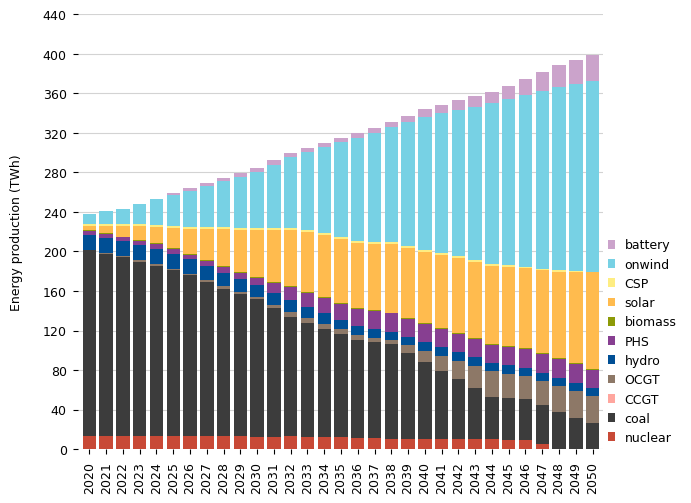

In [ ]:
case ='pypsa'
plt.clf()
if case =='pypsa':
    plt_energy = energy
else:
    plt_energy = ambitions_energy.T

plt_energy = plt_energy.reindex(['nuclear','coal','CCGT','OCGT','hydro','PHS','biomass','solar','CSP','onwind','battery'])
ax = plt_energy.T.plot.bar(figsize=(7,6),stacked=True,color=colour_map,width=0.8,zorder=2)
ax.grid(axis='y', color='lightgray',linestyle='-',zorder=1)  # add light grey horizontal grid lines only
plt.ylabel('Energy production (TWh)')
plt.xlabel("")
plt.yticks(range(0, 440+1, 40))  # set y-axis ticks to increments of 20

for spine in ax.spines:
    ax.spines[spine].set_visible(False)

# cnt=0
# height = 0     
# dy = 1  # adjust this value to fine-tune the vertical spacing between annotations
# for bar in ax.containers:
#     end_energy = (energy).iloc[cnt,-1]
#     x = len(energy.T)-1
#     y = end_energy/2+height+dy*cnt  # adjust y position based on index of the bar
#     ax.annotate(
#         energy.index[cnt],
#         xy=(x, y),
#         xytext=(5, 0),
#         textcoords="offset points",
#         va="center",
#         color=ax.containers[cnt][-1].get_facecolor(),
#         #arrowprops=dict(arrowstyle='-', connectionstyle='angle3,angleA=0,angleB=-90', facecolor='black', width=1, headwidth=4, headlength=4),  # change arrow to line
#     )
#     height += end_energy
#     cnt+=1

handles, labels = ax.get_legend_handles_labels()
ax.legend().set_visible(True)
ax.legend(handles[::-1], labels[::-1],handlelength=0.5, bbox_to_anchor=(1.0, 0), loc='lower left', borderaxespad=0.,frameon=False)

plt.savefig('energy_'+scenario+'_'+case, dpi=150, bbox_inches='tight')


In [ ]:
period_weighting = n[scenario].investment_period_weightings["years"]
weightings = n[scenario].snapshot_weightings.mul(period_weighting, level=0, axis=0).loc[
    n[scenario].snapshots
]
em_pu = n[scenario].generators.carrier.map(n[scenario].carriers.co2_emissions)
em_pu = (
    weightings["generators"].to_frame("weightings")
    @ em_pu.to_frame("weightings").T
)
emissions = em_pu.mul(n[scenario].generators_t.p/n[scenario].generators.efficiency).groupby(n[scenario].generators_t.p.index.get_level_values(0)).sum().sum(axis=1)
emissions

period
2020    4.521061e+08
2022    4.336779e+08
2024    4.126649e+08
2026    3.877202e+08
2028    3.553201e+08
2030    3.309807e+08
2032    2.880996e+08
2034    2.608068e+08
2036    2.361337e+08
2038    2.248025e+08
2040    1.862780e+08
2042    1.538017e+08
2044    1.195625e+08
2046    1.136982e+08
2048    1.099091e+08
2050    2.141678e+08
dtype: float64